# Bayesian Modeling and Markov Chain Monte Carlo

### Data Science 350

## Overview

In a previous lesson we explored the basics of Bayesian parameter estimation. The methods we used are restricted to only simple models. This lesson introduces you to a general and flexible form of Bayesian modeling using the **Markov chain Monte Carlo (MCMC)** methods. MCMC methods can be extended to extremely complex models, including **Bayesian hierarchical models**.  

![](img/Flips.png)


***
**Note:** To run this notebook you must have the following packages installed:
- pymc3
***

## Review of Bayes Theorem

Recall Bayes theorem:

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Computing the normalization $P(B)$ is a bit of a mess. But fortunately, we don't always need the denominator. We can rewrite Bayes Theorem as:

$$𝑃(𝐴│𝐵)=𝑘∙𝑃(𝐵|𝐴)𝑃(𝐴)$$

Ignoring the normalizaton constant $k$, we get:

$$𝑃(𝐴│𝐵) \propto 𝑃(𝐵|𝐴)𝑃(𝐴)$$

### Bayesian parameter estimation

How to we interpret the relationships shown above? We do this as follows:

$$Posterior\ Distribution \propto Likelihood \bullet Prior\ Distribution \\
Or\\
𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠│𝑑𝑎𝑡𝑎) \propto 𝑃(𝑑𝑎𝑡𝑎|𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠)𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠) $$

These relationships apply to the observed data distributions, or to parameters in a model (partial slopes, intercept, error distributions, lasso constant,…). 

## Grid Sampling and Scalability

Real-world Bayes models have large numbers of parameters, even into the millions. As a naive approach to Bayesian analysis would be to simply grid sample across the dimensions of the parameter space. However, grid sampling will not scale. To underestand the scaling problem, do the following thought experiment, where each dimension is sampled 100 times:

- For a 1-parameter model: $100$ samples.
- For a 2-parameter model: $100^2 = 10000$ samples.
- For a 3-parameter model: $100^3 = 10^5$ samples.
- For a 100-parameter model: $100^{100} = 10^{102}$ samples. 

As you can see, the compuational complexity of grid sampling has **exponential scaling** with dimensionality. Clearly, we need a better approach. 

## Introduction to Markov Chain Monte Carlo

Large-scale Bayesian models use a family of efficient sampling methods known as **Markov chain Monte Carlo sampling**. Rather that systematically sampling on a grid MCMC methods sample distributions randomly. While MCMC methods are computationally efficient, but requires effort to understand how it works and what to do when things go wrong. 

In [33]:
import numpy as np

### What is a Markov process?

As you might guess from the name, a MCMC sampling uses a chain of **Markov sampling processes**. A Markov process is a **stochastic process** that a makes transition from a current state, $x_t$, to some next state, $x_{t+1}$, with some probability $\Pi$. A Markov process has **no dependency on past states**. We can summarize properties of a Markov process:   
- The probability of transition from one state to another is parameterized by a matrix of probabilities, $\Pi$, of dim N X N for N possible state transitions,  
- $\Pi$  only depends on the current state, $x_t$,     
- The transition can be to current state.   

Since a Markov transition process depends only on the current state and not the history, we say a Markov process is **memoryless**. We can express the sequence of a Markov transition processes as:

$$P(X_{t + 1}| X_t = x_t, x_{t-1}, x_{t-2}, \ldots, x_0) = p(X_{t + 1}| x_t)$$

Notice that, since the Markov process is memoryless, the transition probability only depends on the current state, $x_t$. There is no dependency on any previous states, $\{x_{t-1}, x_{t-2}, \ldots, x_0 \}$. 

For a system with $N$ possible states we can write the **transition probability matrix**, $\Pi$, from one state to another as follows:

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1, N}\\
\pi_{2,1} & \pi_{2,2} & \cdots & \pi_{2,N}\\
\cdots & \cdots & \cdots & \cdots \\
\pi_{N,i} & \pi_{N,2} & \cdots & \pi_{N,N}
\end{bmatrix}\\
where\\
\pi_{i,j} = probability\ of\ transition\ from\ state\ i\ to\ state\ j\\
and\\
\pi_{i,i} = probability\ of\ staying\ in\ state\ i\\
further\\
\pi_{i,j} \ne \pi_{j,i}\ in\ general
$$

Notice that none of these probabilities depend on the previous state history.

### Example of a Markov Process

To make the foregoing more concrete let's construct a simple example. We will start with a system of 3 states, $\{ x_1, x_2, x_3 \}$. The transition matrix is:    

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \pi_{1,3}\\
\pi_{2,1} & \pi_{2,2} & \pi_{2,3}\\
\pi_{3,1} & \pi_{3,2} & \pi_{3,3}
\end{bmatrix}
= 
\begin{bmatrix}
0.5 & 0.0 & 0.6\\
0.2 & 0.3 & 0.4\\
0.3 & 0.7 & 0.0
\end{bmatrix}
$$

There are some key points to notice in this transition probability matrix.   
- The probabilities of transition from a state is given in each column. Necessarily, the probabilities in each column must add to 1.0.  
- The probabilities of a transition to the same state are given along the diagonal of the matrix.   
- Some transitions are not possible. These transitions have a probability of 0.0.    

Let's apply this probability matrix to a set of three possible states. As an example, let the **state vector** represent being in the first state at time step $t$; $\vec{x_t} = [1,0,0]$. After a state transition, we compute the probability of being in each of the three possible states at the next time step, $t+1$, as:  

$$\vec{x}_{t+1}  = \Pi\ \vec{x}_t = 
\begin{bmatrix}
0.5 & 0.0 & 0.6\\
0.2 & 0.3 & 0.4\\
0.3 & 0.7 & 0.0
\end{bmatrix} 
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix} =
\begin{bmatrix}
0.5 \\
0.2 \\
0.3 
\end{bmatrix} 
$$

*****************
**Exercise:**  Based on the transition probability matrix above, answer the following questions:   
1. Which state does not allow transition to the same state? 
2. How many state transitions are required to transition from the second state (second column) to the first state (first column)? 

### From Markov process to Markov chain    

So far, we have only discussed a single step Markov process. That is, the process for a single state transition. What happens when there is a series of transitions? A sequence of such transitions is known as a **Markov chain**. There are two major behaviors observed with Markov Chains:  
1. **Episodic Markov chains** have a **terminal state**. The terminal state can only transition to itself. Once the system is in the terminal state, we say that the episode has ended. Episodic processes are not of direct interest here, and we will not pursue them further.   
2. **Continuous Markov chains** have no terminal state and continue indefinitely, at least in principle. Continuous Markov chains sample probability distribution, and are ideal for estimating Bayesian posterior distributions.  

As already indicated, a Markov chain comprises a number of state transitions, one after another. Consider a chain of $n$ state transitions, $\{t_1, t_2, t_3, \ldots, t_n \}$. Each transition in this process has the probabilities given by the state transition matrix, $\Pi$.            

To estimate the probabilities of being in the states we use a special case of continuous Markov chain. This process is known as a **stationary Markov chain**. We will not discuss the technical mathematical details here. Here we will just summarize the key result: Over a large number of time steps the number of times the states are visited is proportional to the probability of the system being in each of the states. Starting with some initial state, $\vec{x}_0$, we wish to  being in the states, $\vec{p(x)}$, we can write the relationship as a continuous Markov chain:   

$$\Pi\ \Pi\ \Pi\ \ldots \Pi\ \vec{x}_t = \Pi^n\ \vec{x}_t  \xrightarrow[\text{$n \rightarrow \infty$}]{} \vec{p(x)}$$    

Notice that in the above, we can find the probabilities of the states without ever actually knowing the values of the transition matrix, $\Pi$. As long as we can repeatedly sample the stochastic Markov process, we can estimate these probabilities. 

As we proceed with this lesson we will use of a stationary Markov chains to estimate posterior probabilities. The method relies on the result that the state probabilities converge eventually. As a consequence, we can develop flexible methods for sampling posterior distributions using Markov chain Monte Carlo. In summary, the posterior distribution is sampled using a Markov chain and the sampled distribution should converge to the posterior distribution.    

**********************************
**Exercise:** Based on the foregoing, answer the following questions:     
1. Explain how a Markov chain is constructed from a series of Markov transition processes.    
2. After a large number of transitions, the number of times some state have been visited is shown below. Compute the probabilities of each of the states:    

In [34]:
import numpy as np
number_of_visits = np.array([20000, 10000, 7000, 13000])

## Include code to compute the probabilities below:
np.divide(number_of_visits, number_of_visits.sum())

array([0.4 , 0.2 , 0.14, 0.26])

## MCMC and the Metropolis-Hastings Algorithm

Using the principle of sampling Markov chains a number of MCMC algorithms have been developed over time to sample posterior distributions of Bayesian models. The first MCMC sampling algorithm developed is the **Metropolis-Hastings (M-H) algorithm** (Metropolis et al. (1953), Hastings (1970)). This algorithm is often referred to as simply the Metropolis algorithm. 

The Metropolis algorithm has the following steps to estimate the density of the likelihood of the parameters:
1. Pick a starting point in the parameter space. This choice is typically a bit arbitrary. 
2. Evaluate the posterior distribution according to the model. In other words, take a sample of the likelihood $p(data|parameters)$ and compute the posterior.
3. Choose a nearby point in parameter space randomly and evaluate the likelihood at this point, and compute the posterior probability. The new point is selected randomly, using a sampling distribution. The Normal distribution is a common choice of sampling distribution.
4. Use the following decision rule to **accept** or **reject** the new sample: 
  - If the $p(data | parameters)$ of the new point is greater than your current point, accept new point and move there.
  - If the $p(data | parameters)$ of the new point is less than your current point, only accept with probability according to the ratio:  
$$Acceptance\ probability\ = \frac{p(data | new\ parameters)}{p(data | previous\ parameters)}$$.
3. Repeat steps 3 and 4 many times.

Using these many samples, the algorithms converges and the posterior distribution is estimated. The M-H random sampling algorithm is far more **sample efficient** than naive grid sampling. To build some intuition, consider that since the M-H algorithm samples the parameter space we only need to visit a limited number of points, rather than sample an entire grid. 

Now that we have outlined the basic Metropolis-Hastings MCMC algorithm, let's examine some of its properties.
- The M-H algorithm is **guaranteed to eventually converge** to the underlying distribution. But as a practical issue, convergence can be quite slow, perhaps too slow.   
- If there is high **serial correlation** from one sample to the next in M-H chain converges slowly. 
- To ensure efficient convergence the algorithm must be ‘tuned’. The tuning involves finding a good dispersion value for the state selection probability distribution. This parameter determines the size of the jumps the algorithm makes in the parameter space. For example if we use Normal distribution we must pick the variance, $\sigma^2$. If $\sigma^2$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma^2$ is too big, there are large jumps which also slows convergence. 

### M-H algorithm example

Let's make these concepts concrete, by trying a simple example. We will sample to estimate the probability density of a bivariate Normal distribution.     

As a first step, lets plot a set of points with density determined by the bivariate Normal distribution. Execute the code below and examine the resulting plot.

In [35]:
import pymc3

import pandas as pd
import numpy as np
import numpy.random as nr
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

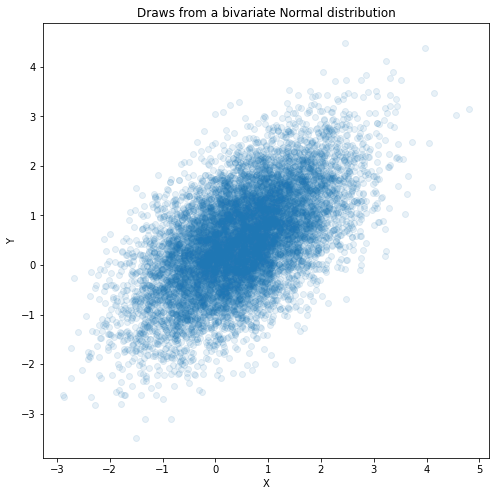

In [36]:
def plot_bi_variate(x, title='Draws from a bivariate Normal distribution'):
    ## Plot bi-variable points
    fig, ax = plt.subplots(figsize=(8,8)) 
    ax.scatter(x[:, 0], x[:, 1], alpha=.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    _=ax.set_title(title)


## Define the covariance and mean of the bivariate Normal. 
sigma = np.array([[1, .6], [.6, 1]])
mu = np.array([.5, .5])
## Sample 10,000 realizations from the bivariate Normal
random_points = np.random.multivariate_normal(mean=mu, cov=sigma,  size=10000)

## Plot the result
plot_bi_variate(random_points)

This plot looks as expected. The density of the dots is proportional to the probability density. You can see the effect of the covariance structure in the elliptical shape of the cloud of points. 

As a next step, let's look at the density of the marginal distributions of the $X$ and $Y$ variables. The code in the cell below plots histogram and density plots of the marginals. Execute this code and examine the result. 

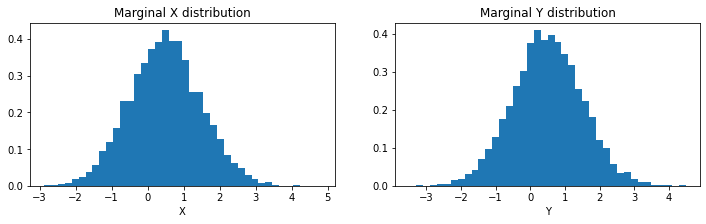

In [37]:
def plot_marginals(x):
    fig, ax = plt.subplots(1, 2, figsize=(12,3)) 
    ax[0].hist(x[:, 0], density=True, bins=40)
    ax[0].set_title('Marginal X distribution')
    ax[0].set_xlabel('X')
    ax[1].hist(x[:, 1], density=True, bins=40)
    ax[1].set_title('Marginal Y distribution')
    ax[1].set_xlabel('Y')  
    
plot_marginals(random_points)

*********************
**Exercise:** Examine the plots above and answer the following questions.   
1. Do these marginal distributions appear approximately Normal? 
2. Are these marginal distributions skewed and with heavy tails? Is this behavior to be expected? 
**********************

Now, we are ready to sample these data using the M-H MCMC algorithm. The code in the cell below performs the following operations:

1. Compute the likelihood of the bi-variate Normal distribution. 
2. Initialize the chain.
3. Initialize some performance statistics.
4. Sample the likelihood of the data using the M-H algorithm.
5. Plot the result.

Execute this code and examine the result. 

(10000, 2)


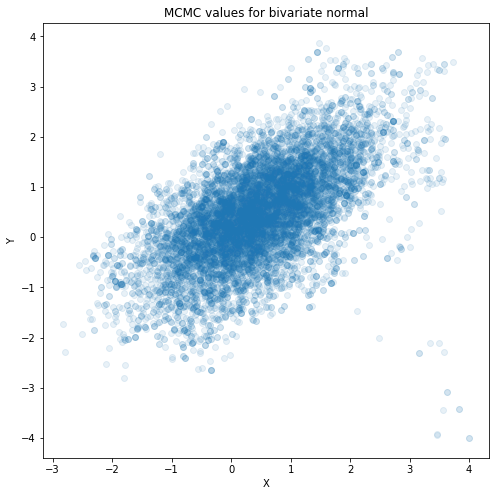

In [38]:
# Calculate the likelihood of a vector `x` for a multivariate normal
# distribution MVN(mu, sigma)
def likelihood(x, mu, sigma):
    return ss.multivariate_normal.pdf(x, mu, sigma)

# Initialize the output array
chain_length = 10000
chain = np.zeros((chain_length,2))
# where to start
chain[0,:] = [4.0,-4.0]


def M_H_sample(start, chain_length, x):
    ## Evaluate the current position
    current_likelihood = likelihood(start[0], mu, sigma)
    # Keep track of how often we accept or reject a proposal
    accept_count = 0
    reject_count = 0

    for i in range(chain_length-1): # chain length minus 1 because we already have a point (the starting point)
        # Sample the direction of the move we'll propose
        delta = nr.multivariate_normal([0, 0], np.diag([.1, .1]))
        # Our new proposal point is our previous position plus the sampled move
        proposed = chain[i,:] + delta
        proposed_likelihood = likelihood(proposed, mu, sigma)
        
        ## Accept according to probability 
        ## Two cases, are taken care of by one if statement since the uniform
        ## distribution is on the range [0-1], exceeding a random value is the 
        ## positive decision.  
        if (nr.uniform() < (proposed_likelihood / current_likelihood)):
            accept_count += 1
            current_likelihood = proposed_likelihood
            chain[i+1,:] = proposed
        else:
            chain[i+1,:] = chain[i,:]
            reject_count += 1 
    ## Return the result        
    return accept_count, reject_count, chain            

## Sample the data distribution
accept_count, reject_count, chain = M_H_sample(chain, chain_length, x=[0,0])
print(chain.shape)
## Plot the result
plot_bi_variate(chain, title='MCMC values for bivariate normal')


Notice the long 'tail' on the sampled distribution. This behavior arrises from the initial wandering of the Markov chain as it finds the high probability regions of the distribution. This period in which the Markov chain wanders is known as the **burn-in period**.

*******************
**Exercise:** You will now investigate the properties of the MCMC burn-in period. As a first start, create a scatter plot of the X, Y variables for the first 5% of the Markov chain.   

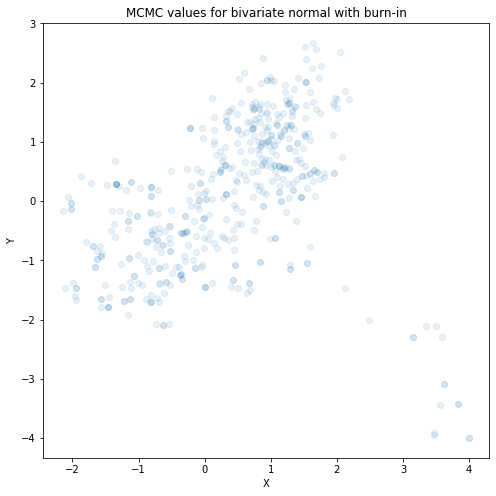

In [39]:
num_burnin = round(.05 * chain_length)
plot_bi_variate(chain[:num_burnin,:], title='MCMC values for bivariate normal with burn-in')

Examine you plot and answer these questions. 
1. How would you describe the reason for the 'trail' of samples from the initial sample value?  
2. What evidence do you see that the sampling is converging toward the actual distribution of these data values?   

************************
**Exercise:**  Next, you will plot the density of the marginal distribution of the MCMC samples beyond the 5% burn-in period. 

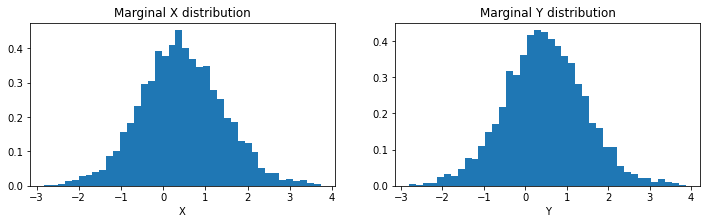

In [40]:
plot_marginals(chain[num_burnin:,:])

Compare your plots of the MCMC sample marginal distributions with the marginal distribution of the original data samples. Do the MCMC sample marginal distributions look reasonably similar to the marginal distributions of the original data samples?    

************************
**Exercise:** Next, you will compare the **Maximum a posteriori or MAP** point of the sampled marginal distributions to the original means for $X$ and $Y$. Using the [Numpy mean function](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) compute an approximation of the MAP for the MCMC sampled distribution. Compute and print this mean for both the burn-in period and the rest of the sample. 

In [41]:
mcmc_map_all = np.mean(chain, axis=0)
mcmc_map_all

array([0.44221898, 0.44978463])

In [42]:
mcmc_map_burnin = np.mean(chain[:num_burnin,:], axis=0)
mcmc_map_burnin

array([0.37267343, 0.10306318])

In [43]:
mcmc_map = np.mean(chain[num_burnin:,:], axis=0)
mcmc_map

array([0.44587927, 0.46803313])

Compare the results of your MAP estimates to the original data with $X = 0.5$ and $Y = 0.5$ and answer these questions. 
1. Is the MAP estimate, excluding the burn-in period, appear to be a reasonable estimate for the original data sample? 
2. Why does excluding the burn-in period from the MAP estimate improve it?

### Convergence and sampling efficiency of MCMC

Let's turn our attention to the convergence properties of the M-H MCMC sampler. While convergence of MCMC sampling to the underlying distribution generally occurs, it can be slow. Unfortunately, it is not unusual for convergence to be too slow to be of practical use. Further, in some cases, convergence may not occur at all.  

The **acceptance rate** and **rejection rate** are key convergence statistics for the M-H algorithm. A low acceptance rate and high rejection rate are signs of poor convergence. Likewise, too few rejections, indicate that the algorithm is not exploring the parameter space sufficiently. The trade-off between these statistics is controlled by the dispersion of the sampling distribution. This hyperparameter is generally determined by trial and error. Unfortunately, there are few useful rules of thumb one can use.     

In [44]:
print('Acceptance rate = %.2f' % (accept_count / chain_length))
print('Rejection rate = %.2f' % (reject_count / chain_length))

Acceptance rate = 0.81
Rejection rate = 0.19


These statistics indicate good convergance with a fairly low rejection rate.

Another way to evaluate the convergence of MCMC algorithms is to look at the **trace** of the samples. The trace is a plot of the sample value with sample number. The code in the cell below plots the trace for both the $x$ and $y$ samples, including the burn-in period. Execute this code and examine the results. 

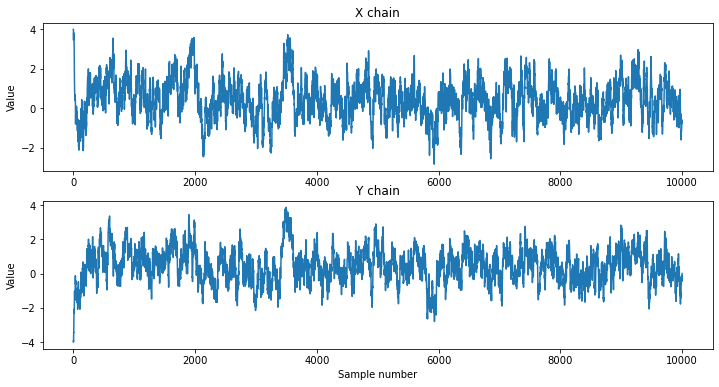

In [45]:
def plot_traces(x):
    fig, ax = plt.subplots(2, 1, figsize=(12,6))
    ax[0].plot(x[:, 0])
    ax[0].set_title('X chain')
    ax[0].set_ylabel('Value')
    ax[1].plot(x[:, 1])
    ax[1].set_title('Y chain')
    ax[1].set_xlabel('Sample number')
    ax[1].set_ylabel('Value')

plot_traces(chain)

Examine these sample traces. Notice that there is a significant excersion during the inital burn-in period. After the inital burn-in you can see that the sampling wanders around the mode of the distribution, as it should. 

Let's look at a close-up view the portion of these traces just after the burn-in period. The code in the cell below plots samples 1000 to 2000. Execute this coded and examine the results. 

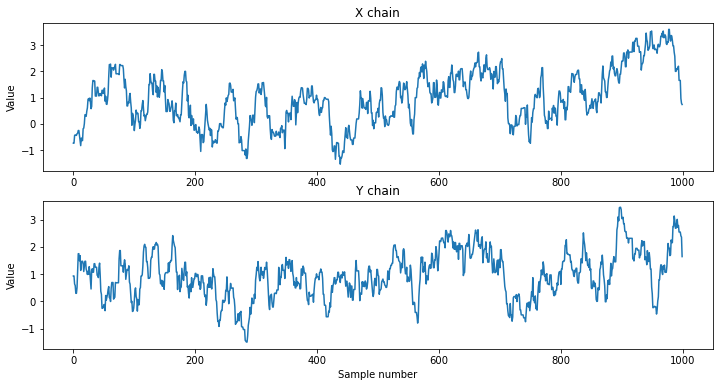

In [46]:
plot_traces(chain[1000:2000, :])

Notice that, for the most part, the samples are centered on the MAP for $x$ and $y$. This is the ideal behavior of the M-H algorithm. 

Finally, let's take a look at the autocorrelation of our samples

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

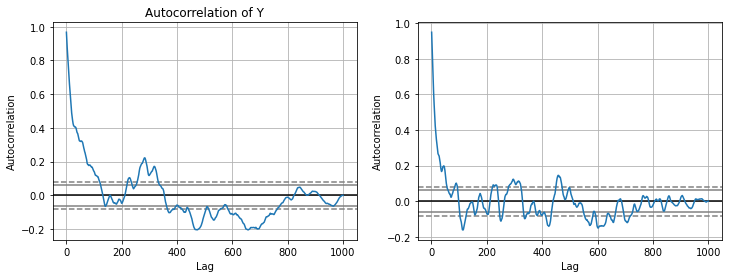

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Autocorrelation of X')
pd.plotting.autocorrelation_plot(chain[1000:2000, 0], ax=ax[0])
ax[0].set_title('Autocorrelation of Y')
pd.plotting.autocorrelation_plot(chain[1000:2000, 1], ax=ax[1])

We can relate sampling efficiency to the autocorrelation of the samples. Intuitively, uncorrelated samples provide maximum information on the distribution being sampled. But, if there is significant autocorrelation, the new information gathered per-sample will be reduced, perhaps greatly so. We can compute an **effective sample size or ESS**. ESS is the ratio between the number of samples adjusted for the autocorrelation and the hypothetical number of uncorrelated samples. In other words, the ratio of actual vs. ideal sampling. For a sample of size $N$, and autocorrelation function at lag k$, $ACF(k)$,we compute the ESS as follows:

$$ESS = \frac{N}{1 + 2 \sum_k ACF(k)}$$    

If the autocorrelation is low, the number of effective samples is high. However, if there is significant autocorrelation the ESS will be significantly less than the raw sample size.

In [48]:
chain.shape

(10000, 2)

In [49]:
def autocorr_chain(x):
    out = np.zeros(x.shape)
    for i in range(x.shape[1]):
        out[:,i] = np.divide(np.correlate(x[:,i], x[:,i], mode='same'), float(x.shape[0]))
    return(out)    

#autocorr_chain(chain[1000:1200,:])

## Other MCMC Sampling Algorithms

Now that you have some experience with the Metropolis-Hastings MCMC algorithm, let's examine some other MCMC sampling methods. The Metropolis-Hastings algorithm is a useful tool. However, this algorithm can suffer from slow convergence for several reasons:

- Samples from the M-H algorithm generally have a fairly high serial correlation, resulting in is low ESS. 
- As already discussed, one must ‘tune’ the state selection probability distribution. For example, if we use a Normal sampling distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, the the jumps are too large, slowing convergence.

As a result of these limimitations, quite a number of MCMC sampling methods have been proposed in a quest to improve sample efficiency. Here, we will only address a few widely used choices.   

### Gibbs sampling

The Gibbs sampler (Geman and Geman, 1984) is an improved MCMC sampler which speeds convergence. The Gibbs sampler is named for the 19th Century physicist Josiah Willard Gibbs and is inspired by statistical mechanics.   

In contrast to the M-H algorithm, the Gibbs sampler samples each dimension of the parameter space sequentially in a round-robin manner. Whereas, the M-H algorithm attempts jumps across all dimensions of the parameter space. 

The basic Gibbs sampler algorithm has the following steps:

1. For an N dimensional parameter space, $\{ \theta_1, \theta_2, \ldots, \theta_N \}$, find a random starting point. 
2. In order, $\{1, 2, 3, \ldots, N\}$, assign the next dimension to sample, starting with dimension $1$.  
3. Sample the marginal distribution of the parameter given the observations, $D$, and other parameter values: $p(\theta_1|D, \theta_2, \theta_3, \ldots, \theta_N)$.
3. Repeat steps 2 and 3 until convergence.    

From this simplified description of the Gibbs sampling algorithm you can infer:

- When compared to the Metropolis-Hastings algorithm, the Gibbs sampler reduces serial correlation through round-robin sampling. The update along each dimension approximately orthogonal to the preceding sample dimensions.    
- There are no tuning parameters since sampling is based on the marginals of the likelihood.

## Hierarchical modeling

So far, we have only worked with models having a single parameter. To extend models to more complex models and fully employ the power of Bayesian methods, we must use **hierarchical models**. To compute these parameters, accounting for their dependency, we will use a hierarchical Bayes model. 

### Chain rule of probability

Creating the required hierarchy employs the **chain rule of probability** to **factor a joint distribution**. Recall the a basic relationship for conditional probability for the point distribution of two random variables, $A$ and $B$:  

$$P(A,B) = P(A|B)P(B)$$

We can expand this relationship to a joint distribution of $N$ variables, $A_1, A_2, A_3, A_4 \ldots, A_n$:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_1 | A_2, A_3, A_4, \ldots, A_n)\ P(A_2, A_3, A_4 \ldots, A_n)$$

In words, a joint distribution can be factored as a distribution of one of the variable, conditioned on the other variables, multiplied by the joint distribution of the other variables. 

We can continue this factorization until we reach an end point:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_1 | A_2, A_3, A_4, \ldots, A_n)\ P(A_2 | A_3, A_4 \ldots, A_n)\ P(A_3| A_4 \ldots, A_n) \ldots P(A_n)$$

> **Note:** The factorization is not unique. We can factor the variables in any order. In fact, for a joint distribution with $n$ variables, there are $n!$ unique factorizations. For example, we can factorize the foregoing distribution as:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_n | A_{n-1}, A_{n-2}, A_{n-3}, \ldots, A_1)\ P(A_{n-1}| A_{n-2}, A_{n-3}, \ldots, A_1)\ P(A_{n-2}| A_{n-3}, \ldots, A_1) \ldots p(A_1)$$     

### Factorization applied to hierarchical models   

We can apply the chain rule of probability to Bayes theorem. This approach allows us to create hierarchical Bayesian models. The hierarchy is determined by the factorization used.     

To make the foregoing concrete let's consider an example of a multi-parameter model; estimating both the mean and variance of a Normal distribution. For this two-parameter model, We can write Bayes theorem like this:

$$p(\theta, \sigma | D) \propto p(D| \theta, \sigma) p(\theta, \sigma)$$

This form looks a bit daunting since the likelihood and the prior both involved two parameters. Fortunately, we can simplify this relationship by applying the chain rule of probability: 

\begin{align}
p(\theta, \sigma | D) &\propto p(D | \theta) p(\theta | \sigma) p(\sigma)\\
&\propto\ Likelihood\ *\ Prior\ of\ \theta\ given\ \sigma\ *\ Prior\ of\ \sigma
\end{align}

As you can see, a complex multi-parameter Bayesian model is transformed into a hierarchy. The factorization has two likelihood functions, each with only a single parameter; the mean and the scale or variance.  

We will use a **hierarchical Bayes model**. The model is considered hierarchical since the quantity we really want to know, the posterior distribution of the label, which we will refer to as $\hat{y}$, depends on the distribution of other model parameters. In this case, the posterior distribution of $\hat{y}$ depends on both the regression coeficients and an error term. We can visualize the hierarchical relationships in this model in the diagram below.

![](img/HierarchicalModel.jpg)
<center> **Hierarchical model for the posterior distribution of y** </center>

In mathematical terms we can define the hierarchical model as follows:
 
1. The prior of the dispursion, $\sigma$, of the Power distribution is defined as the Uniform distribution:
$$U(0, 100)$$
2. The variance (dispersion) of the label values is modeled as an Power distribution:
$$\tau = a x^\sigma = -2 x^\sigma$$
3. The prior distributions of the regression model, $a$ and $b$, are modeled as Normal distributions:
$$N(0, 0.01)$$
4. The regression model for estimating $\hat{y_i}$ is defined by:
$$\hat{y_i} = a + b x_i$$
5. The posterior distribution of the label values is modeled as a Normal distribution:
$$N(\hat{y_i}, \tau)$$
  

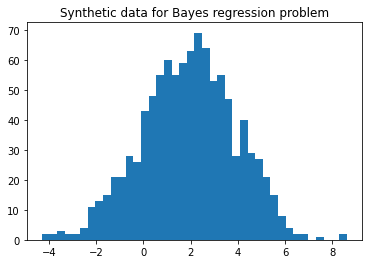

In [50]:
## Set up the data set as a regression problem
N = 1000
y = nr.normal(loc=2.0, scale=2.0, size=N)

plt.hist(y, bins=40)
_ = plt.title('Synthetic data for Bayes regression problem')

In [51]:
def create_model(x, y):
    model = pymc3.Model()

    with model:
        mu_prior = pymc3.Normal('mu_prior', mu=0, sd=10)
        
        # We model the y variable (y_hat) as a linear function of our input 
        # array x, having intercept=a and slope=b.
        y_hat = a + b * x

        sigma = pymc3.Uniform('sigma', lower=0, upper=100)
        tau = pow(sigma, -2)

        # Here we assign our y array as the observed values of the model.
        y_obs = pymc3.Normal('y_obs', mu=y_hat, tau=tau, observed=y)

    return model

## Assignment     

You will create a regression model for the relationship between square footage of the house and the price of the house.  

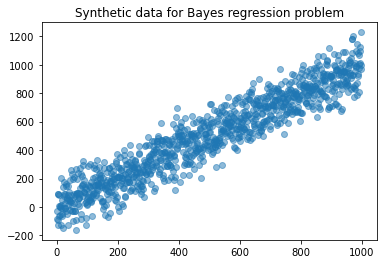

In [52]:
## Set up the data set as a regression problem
N = 1000
x = np.arange(N)
epsilon = nr.normal(0, 100, N)
y = x + epsilon

plt.scatter(x, y, alpha=.5)
_ = plt.title('Synthetic data for Bayes regression problem')

The regression model has two parameters, a slope and an intercept, which we will call $a$ and $b$. We will use a **hierarchical Bayes model**. The model is considered hierarchical since the quantity we really want to know, the posterior distribution of the label, which we will refer to as $\hat{y}$, depends on the distribution of other model parameters. In this case, the posterior distribution of $\hat{y}$ depends on both the regression coeficients and an error term. We can visualize the hierarchical relationships in this model in the diagram below.

![](img/HierarchicalModel.jpg)
<center> **Hierarchical model for the posterior distribution of y** </center>

In mathematical terms we can define the hierarchical model as follows:
 
1. The prior of the dispursion, $\sigma$, of the Power distribution is defined as the Uniform distribution:
$$U(0, 100)$$
2. The variance (dispersion) of the label values is modeled as an Power distribution:
$$\tau = a x^\sigma = -2 x^\sigma$$
3. The prior distributions of the regression model, $a$ and $b$, are modeled as Normal distributions:
$$N(0, 0.01)$$
4. The regression model for estimating $\hat{y_i}$ is defined by:
$$\hat{y_i} = a + b x_i$$
5. The posterior distribution of the label values is modeled as a Normal distribution:
$$N(\hat{y_i}, \tau)$$

### Computing the model with pyMC3

To compute the MCMC samples we will use the `pymc3` package

Each of the variables in the Bayesian model diagram above are represented by pyMC3 objects in the model definition below. The model combines our data (`x` and `y`) with the variables we'd like to estimate: our intercept `a` and slope `b`

Internally, MCMC uses the No U-Turn Sampler (NUTS) for simulation. Instead of proposing new samples with the Metropolis-Hastings acceptance criteria or exploring using the Gibbs sampler approach as described above, NUTS models the exploration as the movement of a particle through a field. The field that guides the movement of the particle through the space is derived from the target probability distribution, such that the particle is drawn towards dense (high likelihood) regions of the space. This strategy directs the exploration of the space rather than using a random wandering behavior as we saw with MCMC methods above, and in doing so is typically more efficient.

In [53]:
def create_model(x, y):
    model = pymc3.Model()

    with model:
        a = pymc3.Normal('a', mu=0, sd=10)
        b = pymc3.Normal('b', mu=0, sd=10)
        
        # We model the y variable (y_hat) as a linear function of our input 
        # array x, having intercept=a and slope=b.
        y_hat = a + b * x

        sigma = pymc3.Uniform('sigma', lower=0, upper=100)
        tau = pow(sigma, -2)

        # Here we assign our y array as the observed values of the model.
        y_obs = pymc3.Normal('y_obs', mu=y_hat, tau=tau, observed=y)

    return model

In [54]:
model = create_model(x, y)

***
**Your turn.** Use a reduced size data set of 50 samples to compute another Bayesian regression model. Ensure you do the following:
1. Use the `numpy.random.choice` function to create an index for the samples of `x` and `y`.
2. You may wish to plot your sampled data to ensure your sampling worked as desired.
3. Define a new model with the sampled dataset.
***

### Evaluating the model

With the model compiled and the posterior sampled, we can now extract the samples. The `pymc3.sample` function extracts the samples from our Markov chain. Execute this code to extract the samples. 

In [55]:
num_chains = 4

## Compute some samples
with model:
    samples = pymc3.sample(1000, chains=num_chains)
samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 6000/6000 [00:10<00:00, 593.78draws/s]
The acceptance probability does not match the target. It is 0.8800666282948394, but should be close to 0.8. Try to increase the number of tuning steps.


<MultiTrace: 4 chains, 1000 iterations, 4 variables>

***
**Your turn.** Extract samples for the model you created with 50 data points. Make sure you give another name to these samples. 
***

We can now examine the convergence properties of the MCMC. As a first step, the code below plots the traces of chains (4) and the marginal density of the slope and intercept parameters, $a$ and $b$. Execute this code and examine the results. 

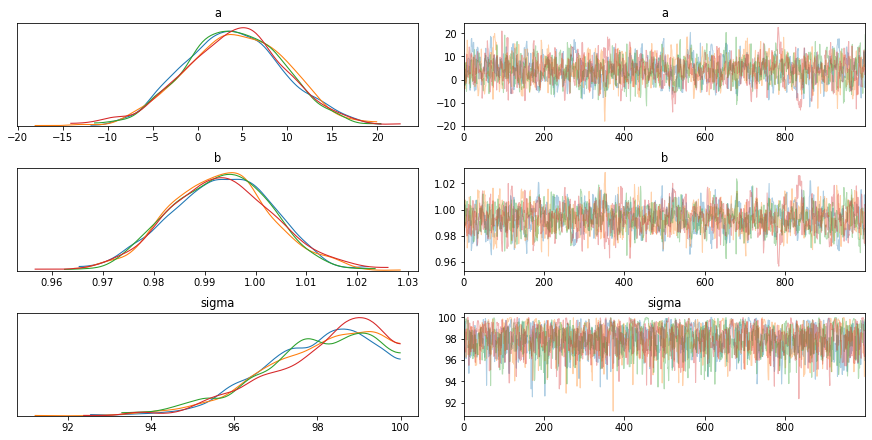

In [56]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = pymc3.plots.traceplot(samples) 

Examine these plots, noting the following:

1. The trace plots on the right show the path of the 4 MCMC chains for the $a$ and $b$ model parameters.
2. The density for the $a$ and $b$ model parameters are shown on the left. The MAP value of the intercept (`a`) is close to the actual value of  0.0, and the MAP value of the slope is close to the actual value of 1.0 (`b`).

***
**Your turn.** Plot the samples you extracted from the model computed with 50 data points. How do these results compare the model computed with 1000 data points.
***

pyMC3 can also print summary statistics for the MCMC sampling.

In [57]:
pymc3.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,4.189,5.487,-5.714,14.547,0.16,0.113,1177.0,1177.0,1173.0,1511.0,1.0
b,0.993,0.010,0.974,1.012,0.00,0.000,1184.0,1183.0,1187.0,1434.0,1.0
sigma,97.977,1.348,95.615,99.988,0.03,0.021,2012.0,1995.0,1597.0,1514.0,1.0


The summary shows a lot of useful information, including:
    
1. The mean of the coefficient values. You can see that the intercept is close to zero and the slope is close to 1
2. The standard deviation (`sd`) of the coefficient values. In this case you can see that the intercept, $a$, is close to 0, as well as the slope, $b$.
3. The sampling error (`mc_error`) is the error arising from the MCMC sampling.
4. The quantiles for the model parameters (`hpd_2.5` and `hpd_97.5`)
5. The effective number of samples (`n_eff`) out of `n_chain` * `n_samples` possible samples
6. The Gelman-Rudin statistic (`Rhat`) which is explained below

***
**Your turn.** Display the summary of the model you created with 50 data points. Compare the results to the model computed using 1000 data points.
***

Let's compaire the results from MCMC samples with a conventional linear model. The code in the cell below computes a linear model and prints the summary. Execute this code and compare the results to the MCMC sample results. 

In [58]:
import sklearn.linear_model


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(x.reshape((-1, 1)), y)

print('Linear model parameters: y ~ (a=%.3f) + (b=%.3f)*x' 
      % (linear_model.intercept_, linear_model.coef_[0]))

Linear model parameters: y ~ (a=5.940) + (b=0.991)*x


The values and error estimates for the intercept and  slope parameters from the conventional linear model are close to those obtained with MCMC sampling. 

The parameters of the linear model match the true intercept and slope closely, but the
 linear model provides no information on the  posterior distribution beyond these simple metrics. For example, there are no quantiles for the coefficients. 

***
**Your turn.** Compute and print the summary of a linear model for the 50 data points you used for your Bayesian model. Compare the results to the Bayesian model and the linear model computed using 1000 data points.
***

Another way to examine the convergence of a Markov is to plot the cumulative values of the coefficients and their standard deviation vs. the sample number. The `cumuplot` function creates just such a plot for a coda Markov chain. Execute the code in the cell below and examine the results for each chain. 

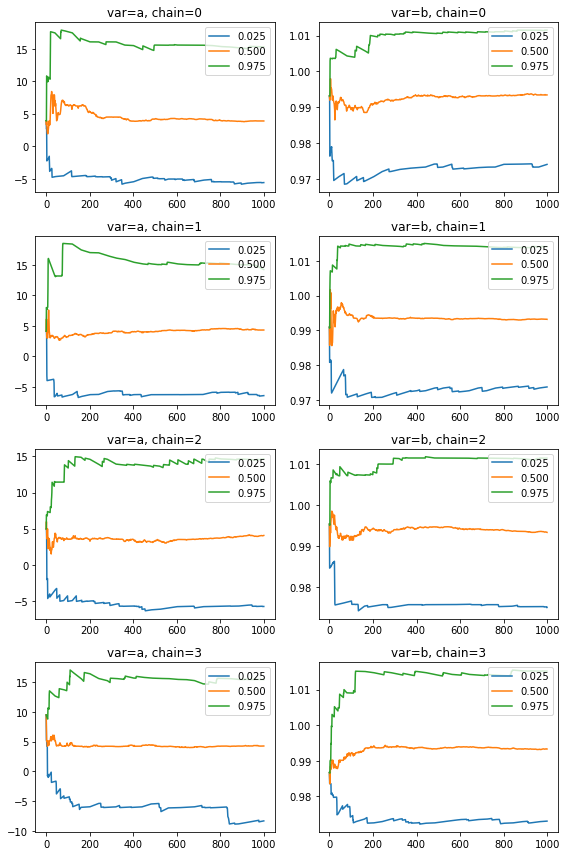

In [59]:
def trace_variable(samples, varnames, quantiles=(0.025, 0.5, 0.975)):
    for i, chain in enumerate(samples.chains):
        for j, varname in enumerate(varnames):
            plt.subplot(len(samples.chains), len(varnames), i * len(varnames) + j + 1)
            values = pd.Series(samples.get_values(varname, chains=chain))
            for q in quantiles:
                plt.plot(
                    values.expanding(min_periods=1).quantile(q), 
                    label='%.3f' % q)
            plt.title('var=%s, chain=%d' % (varname, chain))
            plt.legend(loc='upper right')
    plt.tight_layout()


plt.figure(figsize=(8, 12))
trace_variable(samples, ['a', 'b'])

The plots show that each chain converges to similar values and with similar standard deviations. This indicates that the Markov chains are converging properly.

The **Gelman-Rudin statistic** (Gelman and Rudin, 1992) measures the ratio of the **variance shrinkage between chains** to the **variance shrinkage within chains**. The Gelman-Rudin statistic should coverge to 1.0. The code in the cell below uses the `pymc3.forestplot` function to produce a plot of the Gelman-Rudin statistic and its 95% credible interval. Execute this code and examine the result (R-hat is the Gelman-Rudin statistic). 

array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

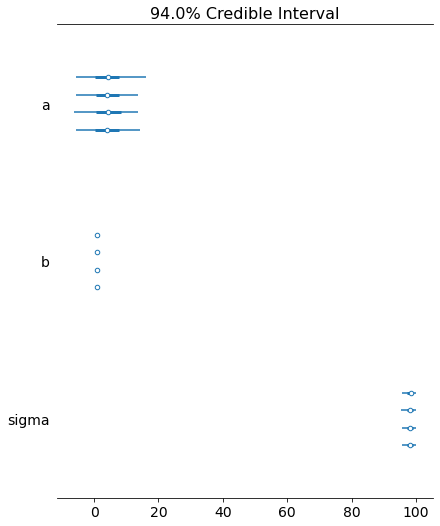

In [60]:
pymc3.forestplot(samples)

We can also get the value of the Gelman-Rudin, $\hat{R}$, statistic, and other diagnostic metrics, for our variables like so:

In [61]:
pymc3.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,4.189,5.487,-5.714,14.547,0.16,0.113,1177.0,1177.0,1173.0,1511.0,1.0
b,0.993,0.010,0.974,1.012,0.00,0.000,1184.0,1183.0,1187.0,1434.0,1.0
sigma,97.977,1.348,95.615,99.988,0.03,0.021,2012.0,1995.0,1597.0,1514.0,1.0


The Gelman-Rudin statistic values for both model parameters converged to near 1.0.

As we already discussed, the convergance of MCMC algorithms is slowed by **autocorrelation** between the samples. `pyMC3` provides the `autocorrplot()` function for examining the autocorrelation in Markov chains. The function creates autocorrelation function plots for each parameter and chain combination. 

To examine the results for the Markov chains, execute the code in the cell below. 

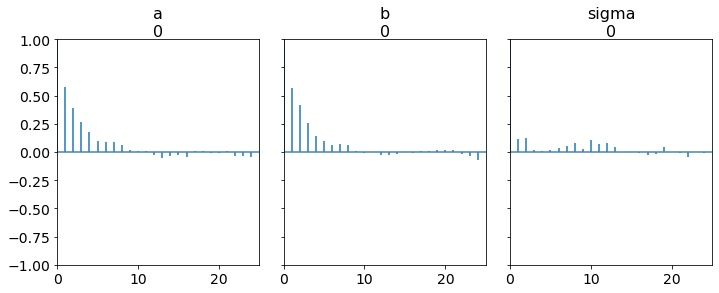

In [62]:
_ = pymc3.autocorrplot(samples, max_lag=25, figsize=(10, 4))

You can see that there are a several significant lag values of the ACF. This means that the convergence of the Markov chains was impeded by this autocorrelation.

Given the significant autocorrelation in the samples, we can compute an **effective sample size or ESS**. If there is significant autocorrelation the ESS will be significantly less than the raw sample size. We can compute the ESS as follows:

$$ESS = \frac{N}{1 + 2 \sum_k ACF(k)}$$

The code in the cell below computes the ESS and rejection rate for the Markov chain. Execute this code and examine the results. 

In [63]:
## What is the effective size of the sample?
pymc3.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,4.189,5.487,-5.714,14.547,0.16,0.113,1177.0,1177.0,1173.0,1511.0,1.0
b,0.993,0.010,0.974,1.012,0.00,0.000,1184.0,1183.0,1187.0,1434.0,1.0
sigma,97.977,1.348,95.615,99.988,0.03,0.021,2012.0,1995.0,1597.0,1514.0,1.0


Note that the effective number of samples is also provided as part of the standard trace summary (see column `n_eff`):

In [64]:
pymc3.summary(samples)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,4.189,5.487,-5.714,14.547,0.16,0.113,1177.0,1177.0,1173.0,1511.0,1.0
b,0.993,0.010,0.974,1.012,0.00,0.000,1184.0,1183.0,1187.0,1434.0,1.0
sigma,97.977,1.348,95.615,99.988,0.03,0.021,2012.0,1995.0,1597.0,1514.0,1.0


You can see that the effective sample size is much lower than the raw sample size. Still, the effective sample sizes appears to be sufficient to provide good estimates of the posterior distributions of the parameters. 

## Summary

In this notebook you have done the following:

- Reviewed the basic properties of a Markov process.
- Perform a simple Markov chain Monte Carlo using the Metropolious-Hastings algorithm.
- Created and computed a hierarchical Bayes model using No U-Turn Sampling.
- Evaluated the convergance of the model. 

#### Copyright 2017, 2018, 2019, 2020, Stephen F Elston. All rights reserved. 